<div style="text-align: center;">
    <a href="https://colab.research.google.com/github/Arrhythmia_Classification/ECG%20Classification.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

In [5]:
!pip install tensorflow


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.2 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 1.2 MB/s eta 0:00:0000:01m00:07
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached gast-0.5.4-py3-none-any.whl (19 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 476.5 kB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 638.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 429.8 kB/s eta 0:00:

In [6]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import wfdb  # For loading and working with PhysioNet data
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from sklearn.model_selection import train_test_split  # For splitting the data

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# If you haven't installed these libraries yet, you can install them using pip
# !pip install numpy matplotlib wfdb scikit-learn tensorflow


In [2]:
import wfdb

# Record name and the PhysioNet database
record_name = '100'
database_name = 'mitdb'

# Load the record from PhysioNet
record = wfdb.rdrecord(record_name, pn_dir=database_name)
annotation = wfdb.rdann(record_name, 'atr', pn_dir=database_name)

# Print the signal and annotation info
print("Signal shape:", record.p_signal.shape)
print("Annotation symbols:", annotation.symbol[:10])


Signal shape: (650000, 2)
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']


In [7]:
def get_segments(signal, annotations, window_size=360):
    segments = []
    labels = []
    for idx, symbol in enumerate(annotations.symbol):
        center = annotations.sample[idx]
        if center < window_size or center > signal.shape[0] - window_size:
            continue  # Skip beats too close to the start or end
        segment = signal[center-window_size:center+window_size]
        segments.append(segment)
        labels.append(symbol)
    return np.array(segments), np.array(labels)

# Get segments and labels
segments, labels = get_segments(record.p_signal[:,0], annotation)  # Using only channel 1 for simplicity

print("Number of segments:", len(segments))
print("Example segment shape:", segments[0].shape)


Number of segments: 2270
Example segment shape: (720,)


In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

# Fit and transform the labels to encode them
encoded_labels = le.fit_transform(labels)

# Check the first few encoded labels
print("Encoded labels example:", encoded_labels[:10])


Encoded labels example: [1 1 1 1 1 1 0 1 1 1]


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'segments' and 'labels' are already defined
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(segments, encoded_labels, test_size=0.2, random_state=42)


In [10]:
from tensorflow.keras.layers import Input

# Define the neural network structure with an Input layer
model = Sequential([
    Input(shape=(720,)),  # Explicitly define the input shape here
    Flatten(),            # Now Flatten doesn't need the input_shape
    Dense(128, activation='relu'),  # First dense layer
    Dense(64, activation='relu'),   # Second dense layer
    Dense(len(set(encoded_labels)), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model summary to understand the architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        92,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,739 (393.51 KB)

 Trainable params: 100,739 (393.51 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9595 - loss: 0.2006 - val_accuracy: 0.9890 - val_loss: 0.0635
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0760 - val_accuracy: 0.9890 - val_loss: 0.0429
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0363 - val_accuracy: 0.9890 - val_loss: 0.0212
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 8.8488e-04
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.9515e-04 - val_accuracy: 1.0000 - v

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.6f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.9984 - loss: 0.0023   
Test accuracy: 99.78%
Test loss: 0.003153


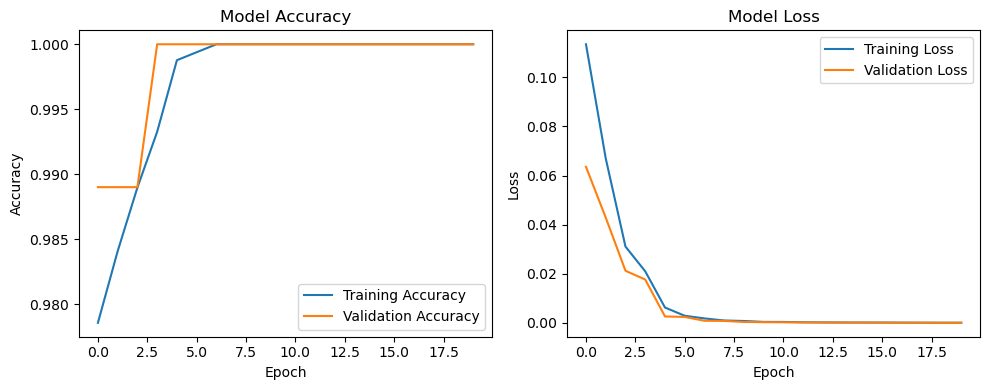

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


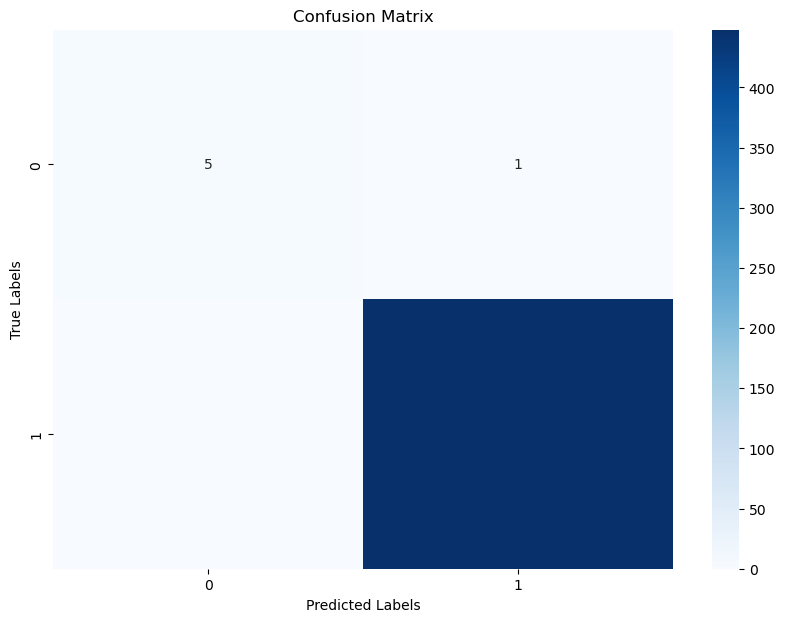

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00       448

    accuracy                           1.00       454
   macro avg       1.00      0.92      0.95       454
weighted avg       1.00      1.00      1.00       454



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


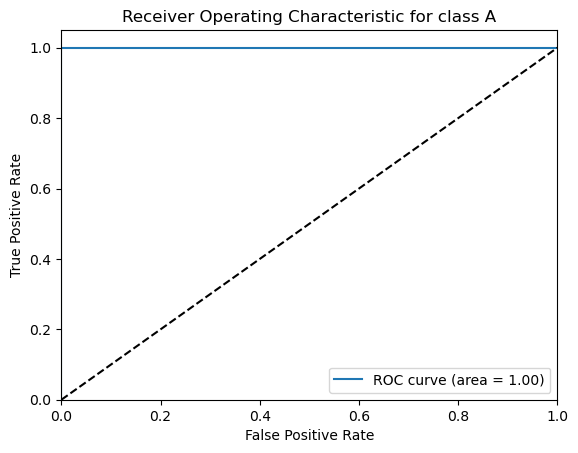

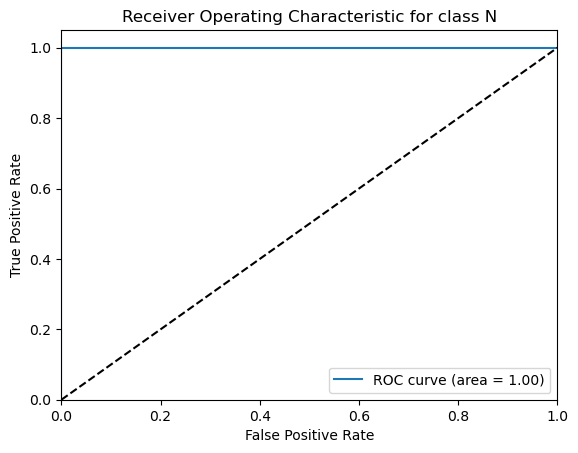

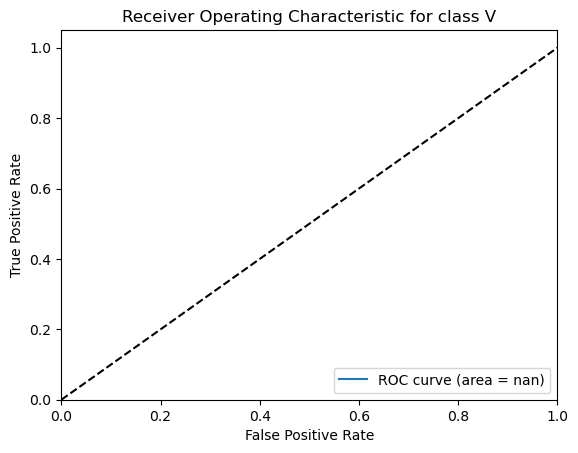

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_pred_bin = model.predict(X_test)  # Get probabilities instead of predicted labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class %s' % le.classes_[i])
    plt.legend(loc="lower right")
    plt.show()


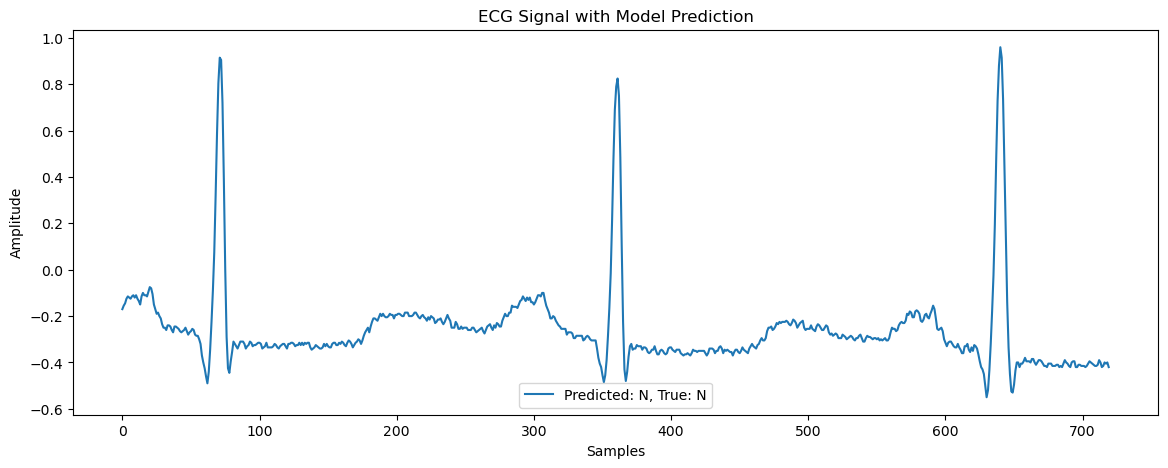

In [18]:
def plot_ecg_with_annotation(index):
    plt.figure(figsize=(14, 5))
    plt.plot(X_test[index], label=f"Predicted: {le.inverse_transform([y_pred_classes[index]])[0]}, True: {le.inverse_transform([y_test[index]])[0]}")
    plt.title('ECG Signal with Model Prediction')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot for a specific index
plot_ecg_with_annotation(10)  # Change index as needed
